# Pedigree aproximation

The distribution of a quantitative trait within a popualtion can generally be aproximated with a normal distribution of constant variance. Even under strong seleciton the variance of this distribution is often only minimally effected. the one process that can cause significant departures from normality is gene flow. This is because gene flow can cause significant amounts of linkage disequilibrium creating correlations betwen combinations of allels that inflate the variance of the trait distribution and cause departures from normality. 

Models can account for linkage disequilibirum by explicitly tracking the full trait distirubtion with funtion aproximation techniques. However, this method is reletively computationally expensive and does not track the structure of the linkage disequilibirum. Here I develop a new method to track this distribution by tracking the linkage disequilbirium explicitly. Tracking the linkage state provides a computational advantage because the distribution of the trait conditional on linkage state is normal with a constant varaince.  

In [656]:
include("pedigreeAproximation.jl")
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")
include("StockRecruitCurves.jl")
using Plots
theme(:wong2)

In [657]:
# initialize demographic model - paramters loaded from DemographicParameters.jl 
mod1 = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod1)
k = 3.0


# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.05
min = -5
max = 10 
Δz = 0.05

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 0.5 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod1,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")

# Test reproduction 

There are some small differences, but I don't think these are a problem at this point. I think it comes down to How I am aproximating the variance in this model  

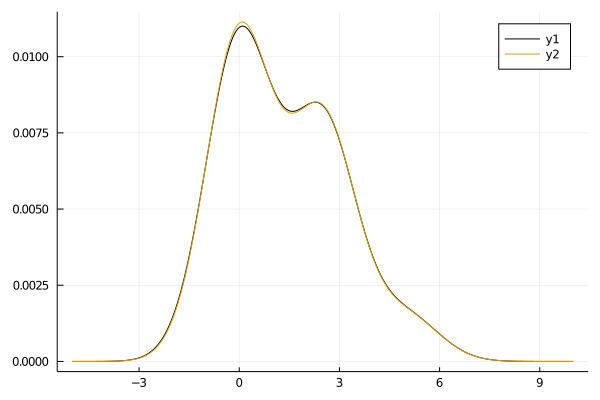

In [658]:
# initialize populations 
pop1 = pedigreeAproximation.init_population(mod1,θ,s,5)
StockRecruitCurves.update_BevetonHolt_k!(pop1.ageStructure.SRCurve, k)
im1 = pedigreeAproximation.init_immigrants(pop1,floor(Int, R_im),μ_im)

pop = AgeTraitStructuredModels.init(mod1,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)

amax = 50
# update pedigree aproximation population for test
pop1.pi[end,1:amax] .=  0.5
pop1.pi[1,1:amax] .=  0.5

pop1.z[end,1:amax] .=  5.0
pop1.z[1,1:amax] .=  0.0


function distribution(x,pi,z)
    return sum(broadcast(i -> pi[i]*pdf(Distributions.Normal(z[i],1.0),x), 1:length(pi)))
end 


# make plot 
grid = min:Δz:max
z,pi,N1 = pedigreeAproximation.reproduction(pop1)
dsn1 = broadcast(x -> distribution(x,pi,z), grid)
p1 = Plots.plot(grid, dsn1 ./ sum(dsn1))
    
    
# update trait distribution population for test
n = pop.abundanceN[1:amax]
pop.abundanceN[1:amax] .= 0.5*n
pop.abundanceH[1:amax] .= 0.5*n

dsn1 = pdf.(Distributions.Normal(0,1.0),pop.grid)
dsn2 = pdf.(Distributions.Normal(5.0,1.0),pop.grid)

pop.traitN[:,1:amax] .=  dsn1 ./ sum(dsn1)
pop.traitH[:,1:amax] .=  dsn2 ./ sum(dsn2)

dsn, N =  AgeTraitStructuredModels.reproduction(pop)

Plots.plot!(p1,pop.grid,dsn)

In [659]:
println(N1)
println(N)

2.884420264530703e13
2.884420264530703e13


# Test selection

again this seems pretty close, probabily not the cause of the large differnces seen in the simulations

30.877985063978212
30.877585935704012


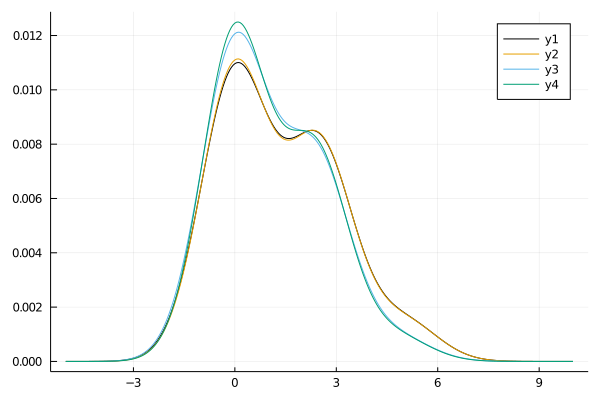

In [660]:
z,pi,N1=pedigreeAproximation.selection(z,pi,N1,pop1)
dsn1 = broadcast(x -> distribution(x,pi,z), grid)
Plots.plot!(p1,grid, dsn1 ./ sum(dsn1))

println(log(N1))

dsn, N = AgeTraitStructuredModels.selection(dsn, N, pop)

println(log(N))
Plots.plot!(p1,grid, dsn ./ sum(dsn))

# Test aging 

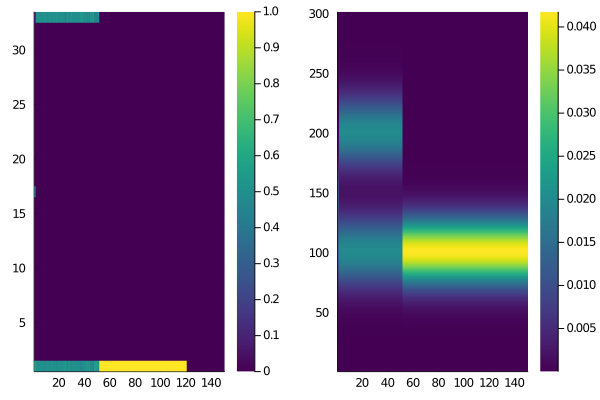

In [661]:

pedigreeAproximation.ageing!(pop1, z, pi, 60)
AgeTraitStructuredModels.ageing!(pop, 60, dsn)

p1 = Plots.heatmap(pop1.pi)
p2 = Plots.heatmap(pop.traitN .+ pop.traitH)
plot(p1,p2)



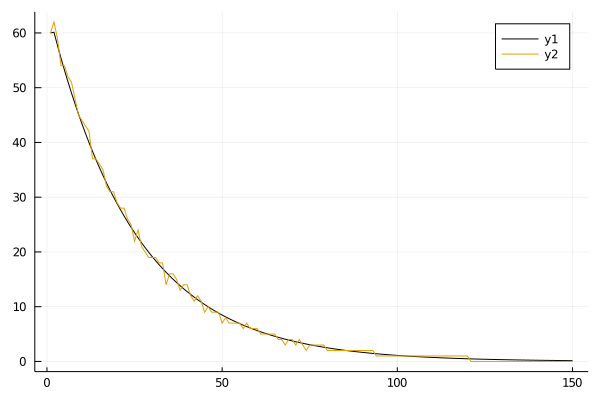

In [662]:
Plots.plot(pop.abundanceN .+ pop.abundanceH)
Plots.plot!(pop1.abundance)

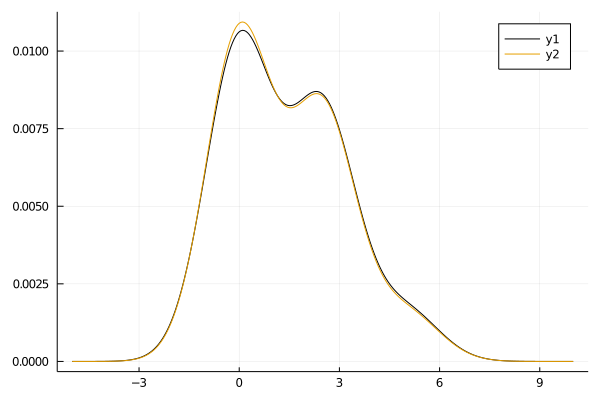

In [663]:
grid = min:Δz:max
pop1.abundance = pop.abundanceN .+ pop.abundanceH
z,pi,N1 = pedigreeAproximation.reproduction(pop1)
dsn1 = broadcast(x -> distribution(x,pi,z), grid)
p1 = Plots.plot(grid, dsn1 ./ sum(dsn1))
    

dsn, N =  AgeTraitStructuredModels.reproduction(pop)
Plots.plot!(p1,pop.grid,dsn)
p1

# Test fitness

In [664]:
theta = pop1.theta
s = pop1.s
V = pop1.V
V_prime = (s+1/V)^(-1)
z_prime = V_prime.*(s*theta .+ z./V)
p_survival = broadcast(i -> pedigreeAproximation.prop_survival(z[i],z_prime[i],s,theta,V, V_prime),1:length(z))
println(sum(p_survival .* pi))


x, N = AgeTraitStructuredModels.selection(dsn, 1.0, pop)
println(N)

0.8434689066808887
0.8884837591220008


# Test recruitment

Again clearly not the issue

In [665]:
z1, pi1, N1 = pedigreeAproximation.recruitment(z, pi, N1, pop1, true)

N =AgeTraitStructuredModels.recruitment(N, pop )
println(N1)
println(N)

45
5.92499202238333e-12


# Test update function 

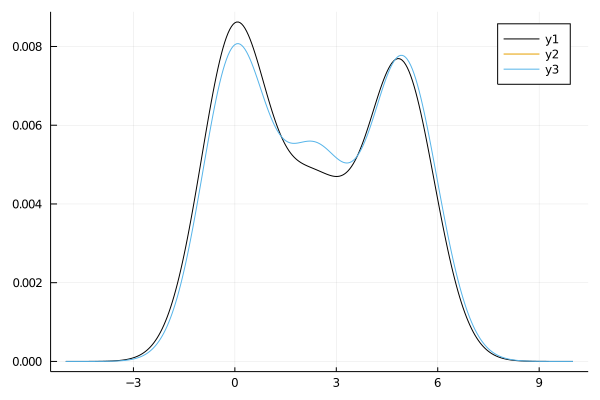

In [666]:
# initialize populations 
pop1 = pedigreeAproximation.init_population(mod1,θ,s,5)
StockRecruitCurves.update_BevetonHolt_k!(pop1.ageStructure.SRCurve, k)
im1 = pedigreeAproximation.init_immigrants(pop1,floor(Int, R_im),μ_im)

pop = AgeTraitStructuredModels.init(mod1,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)

amax = 50
# update pedigree aproximation population for test
pop1.pi[end,1:amax] .=  0.5
pop1.pi[1,1:amax] .=  0.5

pop1.z[end,1:amax] .=  5.0
pop1.z[1,1:amax] .=  0.0


function distribution(x,pi,z)
    return sum(broadcast(i -> pi[i]*pdf(Distributions.Normal(z[i],1.0),x), 1:length(pi)))
end 



# make plot 
grid = min:Δz:max
z1,pi1,n = pedigreeAproximation.time_step_DSI!(pop1, im1)
pi = pop1.pi[:,1] 
z = pop1.z[:,1] 
dsn1 = broadcast(x -> distribution(x,pi,z), grid)
p1 = Plots.plot(grid, dsn1 ./ sum(dsn1))
dsn1 = broadcast(x -> distribution(x,pi1,z1), grid)
Plots.plot!(p1,grid, dsn1 ./ sum(dsn1))    
    
# update trait distribution population for test
n = pop.abundanceN[1:amax]
pop.abundanceN[1:amax] .= 0.5*n
pop.abundanceH[1:amax] .= 0.5*n

dsn1 = pdf.(Distributions.Normal(0,1.0),pop.grid)
dsn2 = pdf.(Distributions.Normal(5.0,1.0),pop.grid)

pop.traitN[:,1:amax] .=  dsn1 ./ sum(dsn1)
pop.traitH[:,1:amax] .=  dsn2 ./ sum(dsn2)

AgeTraitStructuredModels.time_step_DSI!(pop,im)
dsn = (pop.abundanceH[1] .* pop.traitH[:,1] + pop.abundanceN[1] .*pop.traitN[:,1]) ./ (pop.abundanceN[1] .+ pop.abundanceH[1])
Plots.plot!(p1,pop.grid,dsn)

# Test with simulations 

Despite the small differnces between the results in the previous sections it seems like the produce similar results in simulations. 

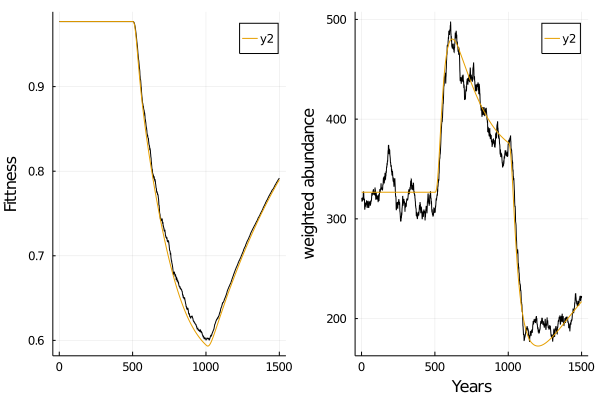

In [679]:
pop1 = pedigreeAproximation.init_population(mod1,θ,s,3)
im1 = pedigreeAproximation.init_immigrants(pop1,floor(Int, R_im),μ_im)

AgeTraitStructuredModels.reset!(pop,s)


T = 1500
t_stock = 500
T_stock = 1000

fitness = zeros(T)
SSB = zeros(T)

fitness1 = zeros(T)
SSB1 = zeros(T)

for t in 1:T
    if t < t_stock
        pedigreeAproximation.time_step_DSI!(pop1,)
        AgeTraitStructuredModels.time_step_DSI!(pop)
    elseif t < T_stock
        pedigreeAproximation.time_step_DSI!(pop1,im1)
        AgeTraitStructuredModels.time_step_DSI!(pop,im)
    else
        pedigreeAproximation.time_step_DSI!(pop1)
        AgeTraitStructuredModels.time_step_DSI!(pop)
    end 

    fitness[t] = pedigreeAproximation.fitness(pop1)
    SSB[t] = pedigreeAproximation.SSB(pop1)
    
    fitness1[t] = AgeTraitStructuredModels.fittness(pop)
    SSB1[t] = AgeTraitStructuredModels.spawning_stock(pop) +AgeTraitStructuredModels.spawning_stockH(pop)

end 
p1 = Plots.plot(fitness, ylab = "Fittness", label = "")
p2 = Plots.plot(SSB, ylab = "weighted abundance", xlab = "Years", label = "")
Plots.plot!(p1, fitness1)
Plots.plot!(p2, SSB1)
plot(p1,p2)

# test reletive performance
One goal of the pedigre aproximation is to be more computationally efficent. This is true for n < 7, despite minimal optimization of the code. 

In [683]:
@time pedigreeAproximation.time_step_DSI!(pop1,im1)
@time AgeTraitStructuredModels.time_step_DSI!(pop,im)
print(" ")

  0.947638 seconds (1.28 M allocations: 63.930 MiB)
  0.005983 seconds (260 allocations: 1.466 MiB)
 

# Test aproximation with fixed trait distribution conditional on the pedigree
This aproximation does a pretty good job initially, but does nto solve any computational bottelnecks

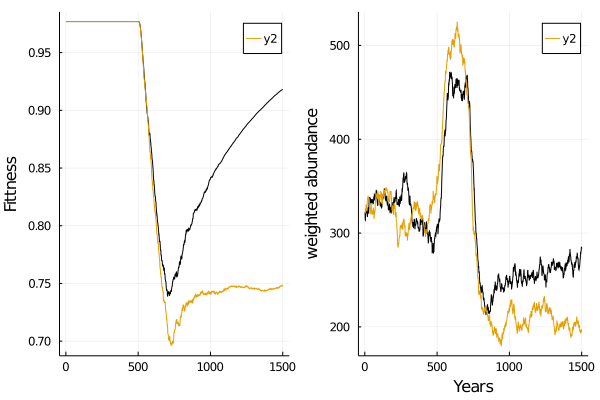

In [757]:
include("pedigreeAproximation.jl")
pop1 = pedigreeAproximation.init_population(mod1,θ,s,4)
im1 = pedigreeAproximation.init_immigrants(pop1,floor(Int, R_im),μ_im)

pop2 = pedigreeAproximation.init_population_fixed(mod1,θ,s,4,μ_im)

T = 1500
t_stock = 500
T_stock = 700

fitness = zeros(T)
SSB = zeros(T)

fitness1 = zeros(T)
SSB1 = zeros(T)

for t in 1:T
    if t < t_stock
        pedigreeAproximation.time_step_DSI!(pop1,)
        pedigreeAproximation.time_step_fixed_DSI!(pop2,0)
    elseif t < T_stock
        pedigreeAproximation.time_step_DSI!(pop1,im1)
        pedigreeAproximation.time_step_fixed_DSI!(pop2,floor(Int, R_im))
    else
        pedigreeAproximation.time_step_DSI!(pop1)
        pedigreeAproximation.time_step_fixed_DSI!(pop2,0)
    end 

    fitness[t] = pedigreeAproximation.fitness(pop1)
    SSB[t] = pedigreeAproximation.SSB(pop1)
    
    fitness1[t] = pedigreeAproximation.fitness_fixed(pop2)
    SSB1[t] = pedigreeAproximation.SSB(pop2) 

end 
p1 = Plots.plot(fitness, ylab = "Fittness", label = "")
p2 = Plots.plot(SSB, ylab = "weighted abundance", xlab = "Years", label = "")
Plots.plot!(p1, fitness1)
Plots.plot!(p2, SSB1)
plot(p1,p2)

# Reletive performance


In [758]:
@time pedigreeAproximation.time_step_DSI!(pop1)
@time pedigreeAproximation.time_step_fixed_DSI!(pop2,0)

  0.000580 seconds (2.91 k allocations: 275.172 KiB)
  0.000638 seconds (2.91 k allocations: 207.375 KiB)


17×150 Array{Float64,2}:
 0.0       0.0       0.0       …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0       …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.380952  0.325581  0.241379  …  0.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.619048  0.674419  0.758621     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.

# Find computational bottlenecks

In [760]:
z,pi,n = pedigreeAproximation.reproduction(pop1)
z,pi,n =  pedigreeAproximation.recruitment(z, pi, n, pop1, true)

pedigreeAproximation.selection(z,pi,n,pop1)
pedigreeAproximation.immigration(z,pi,n,im1)
pedigreeAproximation.ageing_ip!(pop1,z,pi,n)

z,pi,n = pedigreeAproximation.reproduction(pop1)
z,pi,n =  pedigreeAproximation.recruitment(z, pi, n, pop1, true)

@time pedigreeAproximation.reproduction(pop1)
@time pedigreeAproximation.selection(z,pi,n,pop1)
@time pedigreeAproximation.immigration(z,pi,n,im1)
@time pedigreeAproximation.ageing_ip!(pop1,z,pi,n)

  0.000085 seconds (34 allocations: 34.328 KiB)
  0.000033 seconds (27 allocations: 1.688 KiB)
  0.000052 seconds (34 allocations: 3.031 KiB)
  0.000518 seconds (1.80 k allocations: 176.125 KiB)


43